# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [14]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [15]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC3311/NGC3311_I.fits')
data = hdu['PRIMARY'].data

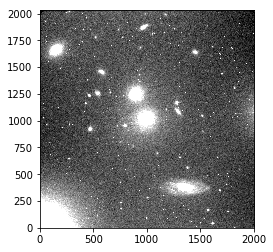

In [16]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=18.4485, vmax=21.1491)

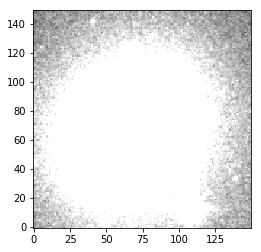

In [31]:
#cut
from astropy.nddata import Cutout2D
position = (900, 1256)
size=(150,150)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=18.4485, vmax=21.1491)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [32]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

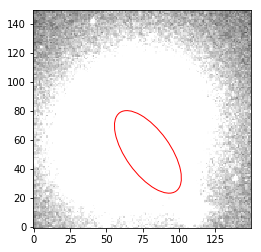

In [33]:
# how does it look?
plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=18.4485, vmax=21.1491)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [28]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [29]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,152.66359897770465,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5086196833020505,149.1168669914299,0.10451280220361032,0.16249226039577458,0.019142345728724107,89.213379517,3.86446910755,0.32811592279550883,13,0,10,0
0.5594816516322556,148.67873493039272,0.1116614487028938,0.16509563602831506,0.01841270958457293,89.213379517,3.7184518279,0.322360470013004,13,0,10,0
0.6154298167954811,148.19883185677483,0.11846347484052103,0.1665253969336894,0.0178535864678963,89.461247126,3.57698067176,0.31546311232162005,13,0,10,0
0.6769727984750293,147.68406075095817,0.12534003402196503,0.16891912150747423,0.017240764615101194,89.6012068818,3.42028324551,0.30793800857167714,13,0,10,0
0.7446700783225323,147.12804129479252,0.1318943151685667,0.17178017391968112,0.016653896629019976,89.8151677799,3.24404274158,0.30088769827852646,13,0,10,0
0.8191370861547855,146.53286128061742,0.1376271687241733,0.17509963727242622,0.015664022792151303,90.1067294096,3.00268678109,0.2837083146921545,13,0,10,0
0.9010507947702641,145.92234693694064,0.1373553134112231,0.1912687562103187,0.012090597873812945,89.9049315691,2.13820623645,0.21139118140478608,13,0,10,0


<ErrorbarContainer object of 3 artists>

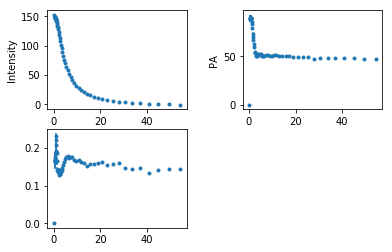

In [30]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
#ax3.set_ylabel('Ellipticity')
 #ax4 = fig.add_subplot(224, sharex=ax1)
 #ax4.errorbar(tab['sma'], tab['x0'],
                  #yerr=tab['x0_err'],
                  #fmt='.')
 #ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [ ]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower')
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower')
ax3.set_title('Residual')